In [1]:
!pip -q install pandas numpy scikit-learn matplotlib joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.utils.class_weight import compute_class_weight


In [3]:
# 1. Load dataset

url = "https://raw.githubusercontent.com/MatteoM95/Default-of-Credit-Card-Clients-Dataset-Analisys/refs/heads/main/dataset/default_of_credit_card_clients.csv"
df = pd.read_csv(url)

print("Shape:", df.shape)
print("Columns:", list(df.columns)[:10],)

Shape: (30000, 25)
Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4']


In [4]:
# 2) Clean column names
df.columns = (
    df.columns.str.strip()
              .str.replace(" ", "_")
              .str.replace("/", "_")
              .str.replace("-", "_")
)

# Identify target
target_col = "default_payment_next_month"
if target_col not in df.columns:
    raise ValueError(f"Target column not found. Available: {df.columns}")

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("\nTarget distribution:\n", y.value_counts())



Target distribution:
 default_payment_next_month
0    23364
1     6636
Name: count, dtype: int64


In [6]:
# 3) Train/test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [8]:
# 4) Preprocess: impute + scale, (This dataset is numeric, so we scale all)

num_cols = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    ],
    remainder="drop"
)

In [11]:
# 5) Class weights (handles imbalance)

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("\nClass weights:", class_weights)


Class weights: {0: 0.6420202236370446, 1: 2.2603126765869277}


In [13]:
# 6) Models

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight=class_weights),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight=class_weights),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight=class_weights
    )
}

def evaluate(name, pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    metrics = {
        "model": name,
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

    print(f"\n========== {name} ==========")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Metrics:", {k: round(v, 4) for k, v in metrics.items() if k != "model"})

    return metrics, pipe

results = []
pipes = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    m, trained_pipe = evaluate(name, pipe)
    results.append(m)
    pipes[name] = trained_pipe

results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False)
print("\nSummary (sorted by ROC-AUC):")
print(results_df.to_string(index=False))

best_name = results_df.iloc[0]["model"]
best_pipe = pipes[best_name]
print("\nBest model:", best_name)



========== LogisticRegression ==========
Confusion Matrix:
 [[3263 1410]
 [ 502  825]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8667    0.6983    0.7734      4673
           1     0.3691    0.6217    0.4632      1327

    accuracy                         0.6813      6000
   macro avg     0.6179    0.6600    0.6183      6000
weighted avg     0.7566    0.6813    0.7048      6000

Metrics: {'precision': 0.3691, 'recall': 0.6217, 'f1': 0.4632, 'roc_auc': np.float64(0.7085)}

========== DecisionTree ==========
Confusion Matrix:
 [[3893  780]
 [ 802  525]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8292    0.8331    0.8311      4673
           1     0.4023    0.3956    0.3989      1327

    accuracy                         0.7363      6000
   macro avg     0.6157    0.6144    0.6150      6000
weighted avg     0.7348    0.7363    0.7355      6000

Metrics: {'precision': 0.4023, '

<Figure size 700x500 with 0 Axes>

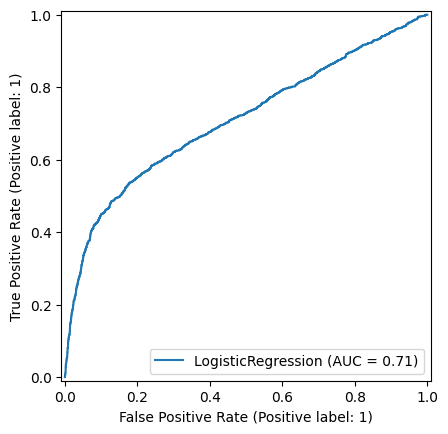

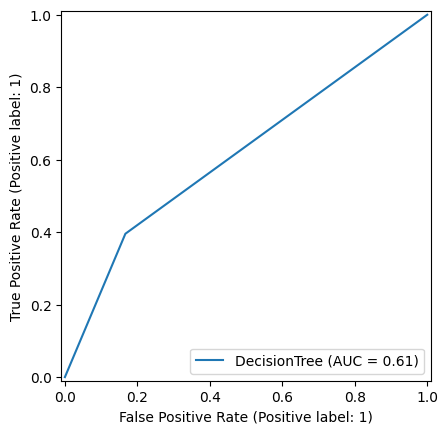

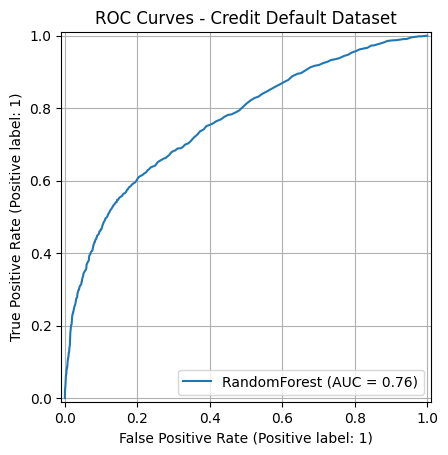

In [14]:
# 7) ROC curves

plt.figure(figsize=(7, 5))
for name, pipe in pipes.items():
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
plt.title("ROC Curves - Credit Default Dataset")
plt.grid(True)
plt.show()

In [15]:
# 8) Save best model

joblib.dump(best_pipe, "best_credit_model.joblib")
print("\n✅ Saved: best_credit_model.joblib")


✅ Saved: best_credit_model.joblib


## Model Objective: Predict whether a client will default next month using demographic, repayment history, billing amounts, and payment amounts.
## Preprocessing: Cleaned column names, applied median imputation for missing values, and standardized numerical features.
## Models Trained: Logistic Regression, Decision Tree, Random Forest (class-weighted due to imbalance).
## Evaluation Metrics: Precision, Recall, F1-score, ROC-AUC, and confusion matrix.
## Results: Random Forest achieved the best discrimination performance with ROC-AUC = 0.764, while Logistic Regression achieved the best default-class detection with Recall = 0.622 and F1 = 0.463.
## Conclusion: Random Forest is preferred for ranking credit risk; Logistic Regression is preferred when maximizing detection of risky clients is the priority.